# Compressing SetFit Models with Knowledge Distillation

## 1. Setup development environment

Our first step is to install SetFit. Running the following cell will install all the required packages for us including Sentence Transformers and PyTorch:

In [ ]:
%pip install setfit neural_compressor optimum[onnxruntime] onnxruntime_extensions

While we're at it, let's turn off some of the warnings from the 🤗 Datasets library and the tokenizers:

In [4]:
import datasets

datasets.logging.set_verbosity_error()

%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


To be able to share your model with the community, there are a few more steps to follow.

First, you have to store your authentication token from the Hugging Face Hub (sign up here if you haven't already!). To do so, execute the following cell and input an access token associated with your account:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Create a performance benchmark

In [388]:
from pathlib import Path
from time import perf_counter

import numpy as np
import torch
from tqdm.auto import tqdm


class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type="MPNet (teacher)"):
        self.trainer = SetFitTrainer(
            model=model, train_dataset=None, eval_dataset=test_dataset
        )
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        accuracy = self.trainer.evaluate()
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.trainer.model.model_body.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_model(self, query="What is the pin number for my account?"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.trainer.model([query])
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.trainer.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.compute_accuracy())
        metrics[self.optim_type].update(self.time_model())
        return metrics

## Train teacher and student baselines

In [373]:
from datasets import load_dataset

dataset = load_dataset("ag_news")

  0%|          | 0/2 [00:00<?, ?it/s]

In [374]:
from setfit import sample_dataset

In [375]:
train_dataset = dataset["train"].train_test_split(seed=42)

In [376]:
train_dataset_teacher = sample_dataset(train_dataset["train"])
train_dataset_student = train_dataset["test"].select(range(1000))
test_dataset = dataset["test"]

## Train models

In [379]:
from setfit import SetFitModel, SetFitTrainer

teacher_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2"
)
teacher_trainer = SetFitTrainer(
    model=teacher_model, train_dataset=train_dataset_teacher
)
teacher_trainer.train()
pb = PerformanceBenchmark(
    model=teacher_trainer.model, dataset=test_dataset, optim_type="MPNet (teacher)"
)
perf_metrics = pb.run_benchmark()

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/80 [00:00<?, ?it/s]

cpu
Model size (MB) - 417.74


***** Running evaluation *****


Average latency (ms) - 12.35 +\- 0.47
Accuracy on test set - 0.823


In [389]:
baseline_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-MiniLM-L3-v2"
)
baseline_trainer = SetFitTrainer(
    model=baseline_model, train_dataset=train_dataset_teacher
)
baseline_trainer.train()
pb = PerformanceBenchmark(baseline_trainer.model, test_dataset, "MiniLM-L3 (student)")
perf_metrics.update(pb.run_benchmark())

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1280
  Num epochs = 1
  Total optimization steps = 80
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/80 [00:00<?, ?it/s]

***** Running evaluation *****


Model size (MB) - 66.36
Accuracy on test set - 0.747
Average latency (ms) - 4.28 +\- 0.44


## Train with knowledge distillation

In [261]:
from setfit import DistillationSetFitTrainer

student_model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-MiniLM-L3-v2"
)
student_trainer = DistillationSetFitTrainer(
    teacher_model=teacher_model,
    train_dataset=train_dataset_student,
    student_model=student_model,
)
student_trainer.train()
pb = PerformanceBenchmark(
    student_trainer.student_model, test_dataset, "MiniLM-L3 (distilled)"
)
perf_metrics.update(pb.run_benchmark())

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 40000
  Num epochs = 1
  Total optimization steps = 2500
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2500 [00:00<?, ?it/s]

Model size (MB) - 66.36


***** Running evaluation *****


Average latency (ms) - 4.26 +\- 0.15
Accuracy on test set - 0.826


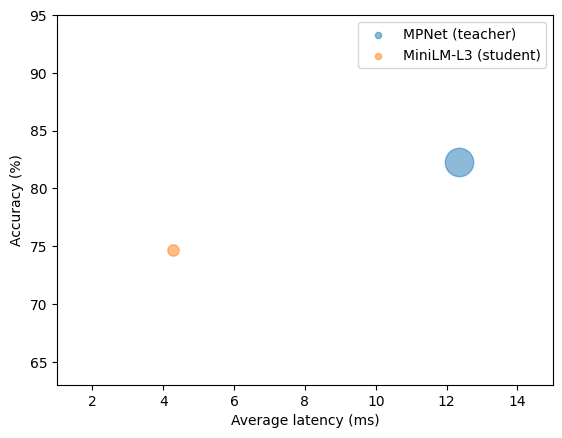

In [390]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(
                df_opt["time_avg_ms"],
                df_opt["accuracy"] * 100,
                alpha=0.5,
                s=df_opt["size_mb"],
                label=idx,
                marker="$\u25CC$",
            )
        else:
            plt.scatter(
                df_opt["time_avg_ms"],
                df_opt["accuracy"] * 100,
                s=df_opt["size_mb"],
                label=idx,
                alpha=0.5,
            )

    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["MPNet (teacher)"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


plot_metrics(perf_metrics, "MiniLM-L3 (distilled)")

## Push to Hub

In [264]:
student_trainer.push_to_hub("setfit-minilm-distilled")

/home/lewis_huggingface_co/miniconda3/envs/hf/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:38: FutureWarning: Deprecated positional argument(s) used in 'push_to_hub': pass repo_path_or_name='setfit-minilm-distilled', repo_url=None, commit_message='Add SetFit model', organization=None, private=None, api_endpoint=None, use_auth_token=None, git_user=None, git_email=None, config=None, skip_lfs_files=False as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  warnings.warn(
/home/lewis_huggingface_co/miniconda3/envs/hf/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'push_to_hub': repo_path_or_name. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Cloning https://huggingface.co/lewtun/setfit-minilm-distilled into local empty directory.


Upload file pytorch_model.bin:   0%|          | 32.0k/66.4M [00:00<?, ?B/s]

Upload file model_head.pkl: 100%|##########| 12.9k/12.9k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/lewtun/setfit-minilm-distilled
   2d4b309..9c0a08a  main -> main



'https://huggingface.co/lewtun/setfit-minilm-distilled/commit/9c0a08a87a55fe4e0b30c490fff0398dcde86998'

## Create ONNX wrapper

In [274]:
from optimum.onnxruntime import ORTModelForFeatureExtraction
from transformers import AutoTokenizer
from pathlib import Path

model_id = "setfit-minilm-distilled/"
onnx_path = Path("onnx")

# load vanilla transformers and convert to onnx
model = ORTModelForFeatureExtraction.from_pretrained(model_id, from_transformers=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# save onnx checkpoint and tokenizer
model.save_pretrained(onnx_path)
tokenizer.save_pretrained(onnx_path)

('onnx/tokenizer_config.json',
 'onnx/special_tokens_map.json',
 'onnx/vocab.txt',
 'onnx/added_tokens.json',
 'onnx/tokenizer.json')

In [275]:
from transformers import Pipeline
import torch.nn.functional as F
import torch

# copied from the model card
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


class SentenceEmbeddingPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        # we don't have any hyperameters to sanitize
        preprocess_kwargs = {}
        return preprocess_kwargs, {}, {}

    def preprocess(self, inputs):
        encoded_inputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='pt')
        return encoded_inputs

    def _forward(self, model_inputs):
        outputs = self.model(**model_inputs)
        return {"outputs": outputs, "attention_mask": model_inputs["attention_mask"]}

    def postprocess(self, model_outputs):
        # Perform pooling
        sentence_embeddings = mean_pooling(model_outputs["outputs"], model_outputs['attention_mask'])
        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings

In [276]:
onnx_pipeline = SentenceEmbeddingPipeline(model, tokenizer)

In [294]:
from optimum.pipelines import pipeline

In [297]:
ort_model = ORTModelForFeatureExtraction.from_pretrained("onnx")
p = pipeline("feature-extraction", model=model, tokenizer=tokenizer)

In [301]:
p("hi", return_tensors="pt").shape

torch.Size([1, 3, 384])

In [360]:
import functools
import onnxruntime

import evaluate
from sklearn.linear_model import LogisticRegression
from optimum.pipelines import ORTModelForFeatureExtraction

accuracy = evaluate.load("accuracy")


def eval_func(model):
    ort_model = ORTModelForFeatureExtraction.from_pretrained("onnx")
    ort_model.model = onnxruntime.InferenceSession(model.SerializeToString(), None)
    onnx_pipeline = SentenceEmbeddingPipeline(ort_model, tokenizer)
    
    def get_data(onnx_pipeline, dataset):
        embeddings = []
        labels = []
        for model_input in tqdm(dataset):
            labels.append([model_input["label"]])
            embedding = onnx_pipeline(model_input["text"])
            embedding = embedding.detach().cpu().numpy()
            embeddings.append(embedding)
        return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)

    # train logistic regressor
    embeddings, labels = get_data(onnx_pipeline, train_dataset_teacher)
    sgd = LogisticRegression(max_iter=200)
    sgd.fit(embeddings, labels)

    # evaluate
    embeddings, labels = get_data(onnx_pipeline, test_dataset)
    y_pred_test_sgd = sgd.predict(embeddings)
    scores = accuracy.compute(predictions=y_pred_test_sgd, references=labels)
    return scores["accuracy"]

In [361]:
def build_dynamic_quant_yaml():
    yaml = """
model:
  name: bert
  framework: onnxrt_integerops
  
device: cpu

quantization:
  approach: post_training_dynamic_quant

tuning:
  accuracy_criterion:
    relative: 0.01
  exit_policy:
    timeout: 0
  random_seed: 9527
    """
    with open("MiniLM_L3_ST_distilled_onnx_dynamic.yaml", "w", encoding="utf-8") as f:
        f.write(yaml)


build_dynamic_quant_yaml()

In [362]:
from neural_compressor.experimental import Quantization, common

onnx_int8_inc_dynamic_model_path = "onnx/MiniLM_L3_int8_dynamic.onnx"
quantizer = Quantization("MiniLM_L3_ST_distilled_onnx_dynamic.yaml")

In [363]:
quantizer.model = common.Model("onnx/model.onnx")
quantizer.eval_func = functools.partial(eval_func)

In [364]:
q_model = quantizer()
q_model

2022-12-13 15:57:18 [INFO] Get FP32 model baseline.


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

2022-12-13 15:57:22 [ERROR] Specified timeout or max trials is reached! Not found any quantized model which meet accuracy goal. Exit.


In [331]:
q_model.save("onnx/model_quantized.onnx")

In [391]:
mm = ORTModelForFeatureExtraction.from_pretrained("onnx", from_file="model_quantized.onnx")
p = pipeline("feature-extraction", model=mm, tokenizer=tokenizer)
# p("hi")

In [366]:
import onnx

onnx_model = onnx.load("onnx/model_quantized.onnx")

In [367]:
eval_func(onnx_model)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

0.824078947368421

In [392]:
def time_model(query="What is the pin number for my account?"):
    latencies = []
    # Warmup
    for _ in range(10):
        _ = p([query])
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = p([query])
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

In [395]:
time_model()

Average latency (ms) - 2.12 +\- 0.09


{'time_avg_ms': 2.12231026016525, 'time_std_ms': 0.09418140866212008}

## Create torch wrapper?

In [221]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[
        "last_hidden_state"
    ]  # First element of model_output contains all token embeddings
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


class SetFitWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        if hasattr(model, "config"):
            self.config = model.config

    def forward(self, input_ids, attention_mask, token_type_ids=None, *args, **kwargs):
        if token_type_ids is not None:
            model_output = self.model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
            )
        else:
            model_output = self.model(
                input_ids=input_ids, attention_mask=attention_mask
            )
        return mean_pooling(model_output, attention_mask)

In [11]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("setfit-mnpet-distilled")

In [163]:
train_dataset_teacher_encoded = train_dataset_teacher.map(
    lambda x: tokenizer(x["text"], padding=True, truncation=True), remove_columns=["text"], batched=True
)
train_dataset_teacher_encoded.set_format("pt")

  0%|          | 0/1 [00:00<?, ?ba/s]

In [164]:
test_dataset_encoded = test_dataset.map(
    lambda x: tokenizer(x["text"], padding=True, truncation=True), remove_columns=["text"], batched=True
)
test_dataset_encoded.set_format("pt")

  0%|          | 0/8 [00:00<?, ?ba/s]

In [212]:
train_dataset_teacher_encoded

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32
})

In [213]:
from torch.utils.data import DataLoader

In [214]:
train_dataloader = DataLoader(train_dataset_teacher_encoded)
test_dataloader = DataLoader(test_dataset_encoded)

In [229]:
import functools

import evaluate
from sklearn.linear_model import LogisticRegression

accuracy = evaluate.load("accuracy")


def eval_func(model):
    setfit_model = SetFitWrapper(model)

    def get_data(model, dataloader):
        embeddings = []
        labels = []
        for idx, model_input in tqdm(enumerate(dataloader)):
            labels.append(model_input.pop("label").numpy())
            embedding = model(**model_input)
            embedding = embedding.detach().cpu().numpy()
            embeddings.append(embedding)
        return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)

    # train logistic regressor
    embeddings, labels = get_data(setfit_model, train_dataloader)
    sgd = LogisticRegression(max_iter=200)
    sgd.fit(embeddings, labels)

    # evaluate
    embeddings, labels = get_data(setfit_model, test_dataloader)
    y_pred_test_sgd = sgd.predict(embeddings)
    scores = accuracy.compute(predictions=y_pred_test_sgd, references=labels)
    return scores["accuracy"]

In [ ]:
model_body = AutoModel.from_pretrained("setfit-mnpet-distilled")
eval_func(model_body)

In [225]:
def build_dynamic_quant_yaml():
    yaml = """
model:
  name: bert
  framework: pytorch
  
device: cpu

quantization:
  approach: post_training_dynamic_quant

tuning:
  accuracy_criterion:
    relative: 0.01
  exit_policy:
    timeout: 0
  random_seed: 9527
    """
    with open("MiniLM_L3_ST_distilled_onnx_dynamic.yaml", "w", encoding="utf-8") as f:
        f.write(yaml)


build_dynamic_quant_yaml()

In [234]:
from neural_compressor.experimental import Quantization, common

onnx_int8_inc_dynamic_model_path = "onnx/MiniLM_L3_int8_dynamic.onnx"
quantizer = Quantization("MiniLM_L3_ST_distilled_onnx_dynamic.yaml")

In [235]:
from transformers import AutoModel

model_body = AutoModel.from_pretrained("setfit-mnpet-distilled")
wrapper = SetFitWrapper(model_body)
quantizer.model = common.Model(model_body)
quantizer.eval_func = functools.partial(eval_func)

In [236]:
q_model = quantizer()
q_model

2022-12-13 14:33:02 [INFO] Pass query framework capability elapsed time: 2.51 ms
2022-12-13 14:33:02 [INFO] Get FP32 model baseline.


0it [00:00, ?it/s]

0it [00:00, ?it/s]

2022-12-13 14:34:55 [INFO] Save tuning history to /home/lewis_huggingface_co/git/workshops/fewshot-learning-in-production/nc_workspace/2022-12-13_13-41-29/./history.snapshot.
2022-12-13 14:34:55 [INFO] FP32 baseline is: [Accuracy: 0.8178, Duration (seconds): 113.0321]
/home/lewis_huggingface_co/miniconda3/envs/hf/lib/python3.9/site-packages/torch/ao/quantization/qconfig.py:92: UserWarning: QConfigDynamic is going to be deprecated in PyTorch 1.12, please use QConfig instead
  warnings.warn("QConfigDynamic is going to be deprecated in PyTorch 1.12, please use QConfig instead")
2022-12-13 14:34:56 [INFO] |******Mixed Precision Statistics*****|
2022-12-13 14:34:56 [INFO] +----------------+----------+---------+
2022-12-13 14:34:56 [INFO] |    Op Type     |  Total   |   INT8  |
2022-12-13 14:34:56 [INFO] +----------------+----------+---------+
2022-12-13 14:34:56 [INFO] |   Embedding    |    3     |    3    |
2022-12-13 14:34:56 [INFO] |     Linear     |    19    |    19   |
2022-12-13 14:34

0it [00:00, ?it/s]

0it [00:00, ?it/s]

2022-12-13 14:36:50 [INFO] Tune 1 result is: [Accuracy (int8|fp32): 0.8203|0.8178, Duration (seconds) (int8|fp32): 114.7929|113.0321], Best tune result is: [Accuracy: 0.8203, Duration (seconds): 114.7929]
2022-12-13 14:36:50 [INFO] |***********************Tune Result Statistics**********************|
2022-12-13 14:36:50 [INFO] +--------------------+-----------+---------------+------------------+
2022-12-13 14:36:50 [INFO] |     Info Type      |  Baseline | Tune 1 result | Best tune result |
2022-12-13 14:36:50 [INFO] +--------------------+-----------+---------------+------------------+
2022-12-13 14:36:50 [INFO] |      Accuracy      |  0.8178   |    0.8203     |     0.8203       |
2022-12-13 14:36:50 [INFO] | Duration (seconds) | 113.0321  |   114.7929    |    114.7929      |
2022-12-13 14:36:50 [INFO] +--------------------+-----------+---------------+------------------+
2022-12-13 14:36:50 [INFO] Save tuning history to /home/lewis_huggingface_co/git/workshops/fewshot-learning-in-produ

PyTorchModel(
  (_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): QuantizedEmbedding(num_embeddings=30522, embedding_dim=384, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      (position_embeddings): QuantizedEmbedding(num_embeddings=512, embedding_dim=384, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      (token_type_embeddings): QuantizedEmbedding(num_embeddings=2, embedding_dim=384, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): DynamicQuantizedLinear(in_features=384, out_features=384, dtype=torch.qint8, qscheme=torch.per_channel_affine)
              (key): DynamicQuantizedLinear(in_fea

In [265]:
best_model = SetFitModel.from_pretrained("setfit-mnpet-distilled-quantized/")

Some weights of the model checkpoint at setfit-mnpet-distilled-quantized/ were not used when initializing BertModel: ['encoder.layer.0.attention.self.value._packed_params.dtype', 'encoder.layer.2.attention.output.dense.zero_point', 'encoder.layer.0.attention.self.key._packed_params._packed_params', 'encoder.layer.1.attention.output.dense._packed_params.dtype', 'encoder.layer.0.intermediate.dense.zero_point', 'encoder.layer.1.output.dense.scale', 'encoder.layer.1.attention.self.query._packed_params.dtype', 'encoder.layer.1.intermediate.dense.scale', 'encoder.layer.1.attention.output.dense.scale', 'encoder.layer.1.attention.self.value._packed_params._packed_params', 'encoder.layer.0.attention.self.value._packed_params._packed_params', 'encoder.layer.2.attention.self.query._packed_params.dtype', 'encoder.layer.1.attention.self.value.zero_point', 'encoder.layer.0.output.dense._packed_params.dtype', 'encoder.layer.1.attention.self.query._packed_params._packed_params', 'encoder.layer.1.atten

In [266]:
PerformanceBenchmark(
    best_model, test_dataset, "MiniLM-L3 (distilled + quantized)"
)
pb.compute_size()

Model size (MB) - 66.36


{'size_mb': 66.36254596710205}

In [255]:
model_body = AutoModel.from_pretrained("setfit-mnpet-distilled-quantized")
eval_func(model_body)

Some weights of the model checkpoint at setfit-mnpet-distilled-quantized were not used when initializing BertModel: ['encoder.layer.0.attention.self.value._packed_params.dtype', 'encoder.layer.2.attention.output.dense.zero_point', 'encoder.layer.0.attention.self.key._packed_params._packed_params', 'encoder.layer.1.attention.output.dense._packed_params.dtype', 'encoder.layer.0.intermediate.dense.zero_point', 'encoder.layer.1.output.dense.scale', 'encoder.layer.1.attention.self.query._packed_params.dtype', 'encoder.layer.1.intermediate.dense.scale', 'encoder.layer.1.attention.output.dense.scale', 'encoder.layer.1.attention.self.value._packed_params._packed_params', 'encoder.layer.0.attention.self.value._packed_params._packed_params', 'encoder.layer.2.attention.self.query._packed_params.dtype', 'encoder.layer.1.attention.self.value.zero_point', 'encoder.layer.0.output.dense._packed_params.dtype', 'encoder.layer.1.attention.self.query._packed_params._packed_params', 'encoder.layer.1.attent

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.3430263157894737

## DOWN TO HERE

## Export to ONNX

In [13]:
from setfit.exporters.onnx import export_onnx

output_path = "setfit_model.onnx"
export_onnx(
    student_trainer.student_model.model_body.to("cpu"),
    student_trainer.student_model.model_head,
    opset=12,
    output_path=output_path,
)

In [42]:
train_dataset["train"][:2]

{'text': ['Oracle sees profits surge 16 Oracle, the world #39;s second largest software producer, has seen first quarter profits surge 16 on the back of strong sales of database products.',
  'Social Security a Priority for White House (AP) AP - THE PROBLEM: Social Security faces a  #36;3.7 trillion shortfall over 75 years.'],
 'label': [2, 0]}

In [49]:
teacher_model(train_dataset["train"].shuffle(seed=0)[:2]["text"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([2, 1])

In [48]:
student_model(train_dataset["train"].shuffle(seed=0)[:2]["text"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([0, 1])

### Quantize with ONNX Runtime

In [50]:
import onnxruntime
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("setfit-mnpet-distilled")
input_text = train_dataset["train"].shuffle(seed=0)[:2]["text"]

inputs = tokenizer(
    input_text,
    padding=True,
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=True,
    return_tensors="np",
)

session = onnxruntime.InferenceSession(output_path)

onnx_preds = session.run(None, dict(inputs))[0]
onnx_preds

array([0, 1], dtype=int64)

In [52]:
import onnx

onnx_model = onnx.load(output_path)

In [58]:
session = onnxruntime.InferenceSession(onnx_model.SerializeToString(), None)
onnx_preds = session.run(None, dict(inputs))[0]
onnx_preds

array([0, 1], dtype=int64)

## Quantize with Intel Neural Compressor

In [77]:
from pathlib import Path

from optimum.onnxruntime import ORTModelForFeatureExtraction
from transformers import AutoTokenizer

onnx_path = Path("onnx")

# load vanilla transformers and convert to onnx
model_id = "setfit-mnpet-distilled"
model = ORTModelForFeatureExtraction.from_pretrained(model_id, from_transformers=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# save onnx checkpoint and tokenizer
model.save_pretrained(onnx_path)
tokenizer.save_pretrained(onnx_path)

('onnx/tokenizer_config.json',
 'onnx/special_tokens_map.json',
 'onnx/vocab.txt',
 'onnx/added_tokens.json',
 'onnx/tokenizer.json')

In [92]:
import torch
import torch.nn.functional as F
from setfit.exporters.utils import mean_pooling
from transformers import Pipeline


class OnnxPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        # we don't have any hyperameters to sanitize
        preprocess_kwargs = {}
        return preprocess_kwargs, {}, {}

    def preprocess(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        )
        return encoded_inputs

    def _forward(self, model_inputs):
        outputs = self.model(**model_inputs)
        return {"outputs": outputs, "attention_mask": model_inputs["attention_mask"]}

    def postprocess(self, model_outputs):
        # Perform pooling
        sentence_embeddings = mean_pooling(
            model_outputs["outputs"], model_outputs["attention_mask"]
        )
        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings

    def encode(self, model_outputs):
        # Perform pooling
        sentence_embeddings = mean_pooling(
            model_outputs["outputs"], model_outputs["attention_mask"]
        )
        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings

In [113]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[
        "last_hidden_state"
    ]  # First element of model_output contains all token embeddings
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9, max=1e9
    )


class TorchModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        if hasattr(model, "config"):
            self.config = model.config

    def forward(self, input_ids, attention_mask, token_type_ids=None, *args, **kwargs):
        if token_type_ids is not None:
            model_output = self.model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
            )
        else:
            model_output = self.model(
                input_ids=input_ids, attention_mask=attention_mask
            )
        sentence_embeddings = mean_pooling(model_output, attention_mask)
        return sentence_embeddings

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(output_dir="tmp")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

In [115]:
import functools

import evaluate
import onnxruntime

accuracy = evaluate.load("accuracy")


def eval_func(model):
    setfit_model = TorchModel(model)

    def get_data(model, dataset):
        embeddings = []
        labels = []
        for model_input in tqdm(dataset):
            labels.append(model_input["label"])
            embedding = model(**model_input)
            embedding = embedding.detach().cpu().numpy()
        return np.concatenate(embeddings, axis=0), np.concatenate(labels, axis=0)

    # train logistic regressor
    embeddings, labels = get_data(setfit_model, train_dataset_teacher)
    sgd = LogisticRegression(max_iter=200)
    sgd.fit(embeddings, labels)

    # evaluate
    embeddings, labels = get_data(setfit_model, test_dataset)
    y_pred_test_sgd = sgd.predict(embeddings)

    return accuracy.compute(y_pred_test_sgd, labels)

In [69]:
import evaluate

accuracy = evaluate.load("accuracy")


def eval_func(model):
    setfit_model = onnxruntime.InferenceSession(onnx_model.SerializeToString(), None)
    input_text = test_dataset["text"][:]
    inputs = tokenizer(
        input_text,
        padding=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="np",
    )
    preds = session.run(None, dict(inputs))[0]
    score = accuracy.compute(preds, test_dataset["label"][:])
    return score

In [108]:
def eval_func(model):
    trainer = SetFitTrainer(
        model=model, train_dataset=train_dataset_teacher, eval_dataset=test_dataset
    )
    trainer.train()
    metrics = trainer.evaluate()
    return metrics["accuracy"]

In [111]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[
        "last_hidden_state"
    ]  # First element of model_output contains all token embeddings
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9, max=1e9
    )


class TorchModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        if hasattr(model, "config"):
            self.config = model.config

    def forward(self, input_ids, attention_mask, token_type_ids=None, *args, **kwargs):
        if token_type_ids is not None:
            model_output = self.model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
            )
        else:
            model_output = self.model(
                input_ids=input_ids, attention_mask=attention_mask
            )
        sentence_embeddings = mean_pooling(model_output, attention_mask)
        return sentence_embeddings

In [116]:
from neural_compressor.experimental import Quantization, common

onnx_int8_inc_dynamic_model_path = "onnx/MiniLM_L3_int8_dynamic.onnx"
model_input = "setfit_model.onnx"
quantizer = Quantization("MiniLM_L3_ST_distilled_onnx_dynamic.yaml")

In [117]:
from transformers import AutoModel

inc_model = AutoModel.from_pretrained("setfit-mnpet-distilled/")

In [118]:
quantizer.model = common.Model(inc_model)
quantizer.eval_func = functools.partial(eval_func)

KeyError: 'onnxrt_integerops'

In [72]:
q_model = quantizer()
q_model

2022-12-13 11:04:43 [INFO] Get FP32 model baseline.
2022-12-13 11:04:52.711928978 [E:onnxruntime:, sequential_executor.cc:369 Execute] Non-zero status code returned while running FusedMatMul node. Name:'MatMul_86_FusedMatMulAndScale' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:342 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool) Failed to allocate memory for requested buffer of size 27990739200

2022-12-13 11:04:52 [ERROR] Unexpected exception RuntimeException("[ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running FusedMatMul node. Name:'MatMul_86_FusedMatMulAndScale' Status Message: /onnxruntime_src/onnxruntime/core/framework/bfc_arena.cc:342 void* onnxruntime::BFCArena::AllocateRawInternal(size_t, bool) Failed to allocate memory for requested buffer of size 27990739200\n") happened during tuning.
Traceback (most recent call last):
  File "/home/lewis_huggingface_co/miniconda3/envs/hf/lib/python3.9/site-pack

In [34]:
q_model.save(onnx_int8_inc_dynamic_model_path)

AttributeError: 'NoneType' object has no attribute 'save'